Basis Pursuit DeNoising (Accelerated PGM)
=========================================

This example demonstrates the use of class [pgm.AcceleratedPGM](../_autosummary/scico.pgm.rst#scico.pgm.AcceleratedPGM) to solve the sparse coding problem problem

  $$\mathrm{argmin}_{\mathbf{x}} \; \| \mathbf{y} - D \mathbf{x} \|_2^2 + \lambda \| \mathbf{x} \|_1\;,$$

where $D$ the dictionary, $\mathbf{y}$ the signal to be represented, and $\mathbf{x}$ is the sparse representation.

In [1]:
import numpy as np

import jax

from scico import functional, linop, loss, plot
from scico.pgm import AcceleratedPGM
plot.config_notebook_plotting()

Construct a random dictionary, a reference random sparse representation, and a test signal consisting of the synthesis of the reference sparse representation.

In [2]:
m = 512  # Signal size
n = 4 * m  # Dictionary size
s = 32  # Sparsity level (number of non-zeros)
σ = 0.5  # Noise level

np.random.seed(12345)
D = np.random.randn(m, n)
L0 = np.linalg.norm(D, 2) ** 2

x_gt = np.zeros(n)  # true signal
idx = np.random.permutation(list(range(0, n - 1)))
x_gt[idx[0:s]] = np.random.randn(s)
y = D @ x_gt + σ * np.random.randn(m)  # synthetic signal

x_gt = jax.device_put(x_gt)  # Convert to jax array, push to GPU
y = jax.device_put(y)  # Convert to jax array, push to GPU

Set up the forward operator and AcceleratedPGM solver object.

In [3]:
maxiter = 100
λ = 2.98e1
A = linop.MatrixOperator(D)
f = loss.SquaredL2Loss(y=y, A=A)
g = λ * functional.L1Norm()
solver = AcceleratedPGM(f=f, g=g, L0=L0, x0=A.adj(y), maxiter=maxiter, verbose=True)

Run the solver.

In [4]:
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Iter  Objective  L         Residual
-----------------------------------
   0  7.795e+09  4.611e+03  4.126e+03


   1  2.097e+09  4.611e+03  1.310e+03
   2  5.399e+08  4.611e+03  4.524e+02
   3  1.406e+08  4.611e+03  1.845e+02
   4  4.021e+07  4.611e+03  1.002e+02
   5  1.382e+07  4.611e+03  6.608e+01
   6  5.955e+06  4.611e+03  4.542e+01
   7  3.351e+06  4.611e+03  3.125e+01
   8  2.373e+06  4.611e+03  2.261e+01
   9  1.771e+06  4.611e+03  1.751e+01
  10  1.211e+06  4.611e+03  1.369e+01
  11  7.238e+05  4.611e+03  1.023e+01
  12  3.867e+05  4.611e+03  7.277e+00
  13  2.045e+05  4.611e+03  5.249e+00
  14  1.251e+05  4.611e+03  4.212e+00
  15  9.184e+04  4.611e+03  3.683e+00
  16  7.175e+04  4.611e+03  3.203e+00
  17  5.452e+04  4.611e+03  2.665e+00
  18  4.005e+04  4.611e+03  2.153e+00
  19  2.904e+04  4.611e+03  1.756e+00
  20  2.102e+04  4.611e+03  1.476e+00
  21  1.503e+04  4.611e+03  1.254e+00
  22  1.064e+04  4.611e+03  1.066e+00
  23  7.613e+03  4.611e+03  9.034e-01
  24  5.804e+03  4.611e+03  7.621e-01
  25  4.800e+03  4.611e+03  6.525e-01
  26  4.155e+03  4.611e+03  5.744e-01
  27  3.596e

  87  8.196e+02  4.611e+03  2.319e-03
  88  8.196e+02  4.611e+03  2.407e-03
  89  8.196e+02  4.611e+03  2.051e-03
  90  8.195e+02  4.611e+03  1.814e-03
  91  8.195e+02  4.611e+03  1.688e-03
  92  8.195e+02  4.611e+03  1.948e-03
  93  8.195e+02  4.611e+03  1.494e-03
  94  8.195e+02  4.611e+03  1.362e-03
  95  8.195e+02  4.611e+03  1.294e-03
  96  8.195e+02  4.611e+03  1.317e-03
  97  8.195e+02  4.611e+03  1.384e-03
  98  8.195e+02  4.611e+03  1.132e-03
  99  8.195e+02  4.611e+03  1.059e-03


Plot the recovered coefficients and convergence statistics.

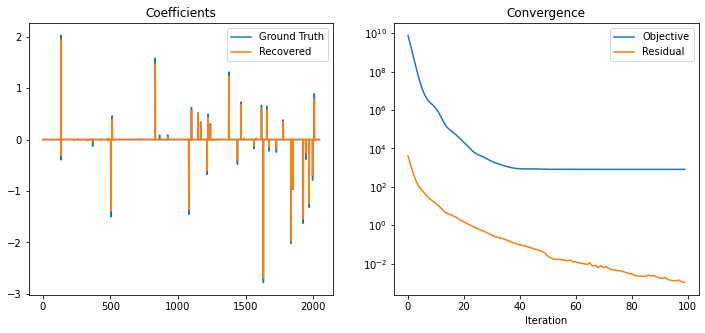

In [5]:
fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot.plot(
    np.vstack((x_gt, x)).T,
    title="Coefficients",
    lgnd=("Ground Truth", "Recovered"),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack((hist.Objective, hist.Residual)).T,
    ptyp="semilogy",
    title="Convergence",
    xlbl="Iteration",
    lgnd=("Objective", "Residual"),
    fig=fig,
    ax=ax[1],
)
fig.show()